<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/main/G2_ML/1_8/K7_v1_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K7 Mode PINN v1.8

**Physics-Informed Neural Network for G2 Holonomy Metrics with Breathing/Flux Diagnostics**

## Overview

This notebook extends v1.6 with:
1. **Breathing/Flux Module**: Visible/hidden H3 mode decomposition along TCS neck
2. **Yukawa Extraction**: Clean numerical computation of triple overlap integrals
3. **Post-hoc Metric Fitting**: Analytic approximation of learned g_ij(x)

## Design Principles

- **Core geometry preserved**: All v1.6 topological targets (b2=21, b3=77, det(g)=65/32, kappa_T=1/61)
- **Speculative quantities as diagnostics**: 43/77 ratio, -1/2 flux, tau period are SOFT probes
- **Modular architecture**: Easy to disable breathing losses (weights=0) for pure geometry mode

## References

- v1.6: K7_GIFT_v1_6.ipynb (SVD-orthonormal harmonic basis)
- GIFT Framework: publications/gift_2_2_main.md

## Section 1: Imports and Configuration

In [ ]:
# =============================================================================
# SECTION 1: IMPORTS AND CONFIGURATION
# =============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional, Any
from pathlib import Path
import json
import time
from fractions import Fraction

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Output directory
OUTPUT_DIR = Path("outputs_v1_8")
OUTPUT_DIR.mkdir(exist_ok=True)
(OUTPUT_DIR / "checkpoints").mkdir(exist_ok=True)


Using device: cuda


In [ ]:
# =============================================================================
# EXPERIMENT CONFIGURATION (Dataclass)
# =============================================================================

@dataclass
class GeometryConfig:
    """Configuration for K7 manifold geometry."""
    dim: int = 7
    coordinate_type: str = "TCS"  # "T7" or "TCS"
    has_neck: bool = True

    # Topological constants (from GIFT v2.2)
    b2_K7: int = 21          # Second Betti number
    b3_K7: int = 77          # Third Betti number
    b3_local: int = 35       # Local Lambda^3 decomposition
    b3_global: int = 42      # Global TCS-induced modes
    dim_G2: int = 14         # dim(G2)
    p2: int = 2              # Binary duality

    # Target metric invariants
    target_det_g: float = 65/32      # = 2.03125
    target_kappa_T: float = 1/61     # = 0.016393...


@dataclass
class BreathingConfig:
    """Configuration for breathing/flux diagnostics.

    IMPORTANT: These are SOFT diagnostics, not hard constraints.
    The speculative values (43/77, -1/2, tau) are measured, not imposed.
    """
    enable: bool = True

    # Speculative target values (for diagnostics only)
    target_flux: float = -0.5              # -1/p2 hypothesis
    target_visible_ratio: float = 43/77   # ~ 0.558
    target_period: float = 3472/891       # tau = 3.896... (GIFT hierarchy parameter)

    # Loss weights (SMALL to avoid dominating geometry)
    loss_weight_flux: float = 1e-3
    loss_weight_ratio: float = 1e-3
    loss_weight_period: float = 1e-4

    # Mode split configuration
    n_visible: int = 43
    n_hidden: int = 34  # 77 - 43

    # Neck parameterization
    lambda_mid: float = 0.5  # Boundary between visible/hidden regions


@dataclass
class TrainingConfig:
    """Training hyperparameters."""
    # Phase 1: Geometry-only
    n_epochs_core: int = 5000
    lr_core: float = 1e-3

    # Phase 2: Geometry + breathing
    n_epochs_breathing: int = 2000
    lr_breathing: float = 5e-4
    freeze_phi_in_breathing: bool = False

    # General
    batch_size: int = 2048
    weight_decay: float = 1e-5
    scheduler_patience: int = 500
    scheduler_factor: float = 0.5
    max_grad_norm: float = 1.0


@dataclass
class LoggingConfig:
    """Logging and checkpointing configuration."""
    log_every: int = 100
    save_checkpoints: bool = True
    checkpoint_dir: str = "outputs_v1_8/checkpoints"
    verbose: bool = True


@dataclass
class ExperimentConfig:
    """Master configuration combining all sub-configs."""
    geometry: GeometryConfig = field(default_factory=GeometryConfig)
    breathing: BreathingConfig = field(default_factory=BreathingConfig)
    training: TrainingConfig = field(default_factory=TrainingConfig)
    logging: LoggingConfig = field(default_factory=LoggingConfig)

    def to_dict(self) -> Dict:
        return {
            'geometry': self.geometry.__dict__,
            'breathing': self.breathing.__dict__,
            'training': self.training.__dict__,
            'logging': self.logging.__dict__
        }

    def save(self, path: str):
        with open(path, 'w') as f:
            json.dump(self.to_dict(), f, indent=2)


# Create default configuration
CONFIG = ExperimentConfig()
print("Configuration loaded:")
print(f"  Geometry: dim={CONFIG.geometry.dim}, b2={CONFIG.geometry.b2_K7}, b3={CONFIG.geometry.b3_K7}")
print(f"  Breathing: enabled={CONFIG.breathing.enable}, target_flux={CONFIG.breathing.target_flux}")
print(f"  Training: core_epochs={CONFIG.training.n_epochs_core}, batch={CONFIG.training.batch_size}")


Configuration loaded:
  Geometry: dim=7, b2=21, b3=77
  Breathing: enabled=True, target_flux=-0.5
  Training: core_epochs=5000, batch=2048


## Section 2: Geometry Core (from v1.6)This section contains the core geometric operations:- Coordinate sampling on T^7 / TCS- PhiNetwork for learning the G2 3-form- Metric reconstruction from phi- Exterior derivatives and Hodge star- Torsion-free conditions

In [ ]:
# =============================================================================
# SECTION 2.1: COORDINATE SAMPLING
# =============================================================================

def sample_T7_coords(batch_size: int, device: torch.device) -> torch.Tensor:
    """Sample uniformly on T^7 (7-torus with period 2*pi)."""
    return torch.rand(batch_size, 7, device=device) * 2 * np.pi


def sample_TCS_coords(batch_size: int, device: torch.device,
                      lambda_range: Tuple[float, float] = (0.0, 1.0)) -> torch.Tensor:
    """Sample on TCS (Twisted Connected Sum) parameterization."""
    coords = torch.zeros(batch_size, 7, device=device)
    coords[:, 0] = torch.rand(batch_size, device=device) * (lambda_range[1] - lambda_range[0]) + lambda_range[0]
    coords[:, 1:] = torch.rand(batch_size, 6, device=device) * 2 * np.pi
    return coords


def split_TCS_coords(coords: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Split TCS coordinates into neck (lambda) and transverse (xi) components."""
    return coords[:, 0:1], coords[:, 1:]


def sample_coords(batch_size: int, config: GeometryConfig, device: torch.device) -> torch.Tensor:
    """Unified coordinate sampling based on configuration."""
    if config.coordinate_type == "T7":
        return sample_T7_coords(batch_size, device)
    elif config.coordinate_type == "TCS":
        return sample_TCS_coords(batch_size, device)
    else:
        raise ValueError(f"Unknown coordinate type: {config.coordinate_type}")


# Test
test_coords = sample_TCS_coords(16, DEVICE)
lam, xi = split_TCS_coords(test_coords)
print(f"TCS coords shape: {test_coords.shape}, lambda: [{lam.min():.3f}, {lam.max():.3f}]")


TCS coords shape: torch.Size([16, 7]), lambda: [0.010, 0.923]


In [ ]:
# =============================================================================
# SECTION 2.2: NEURAL NETWORK ARCHITECTURE
# =============================================================================

class FourierFeatures(nn.Module):
    """Random Fourier features for periodic coordinate encoding."""

    def __init__(self, input_dim: int = 7, n_modes: int = 32, scale: float = 1.0):
        super().__init__()
        self.n_modes = n_modes
        self.output_dim = 2 * n_modes
        B = torch.randn(input_dim, n_modes) * scale
        self.register_buffer('B', B)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        proj = 2 * np.pi * torch.matmul(x, self.B)
        return torch.cat([torch.cos(proj), torch.sin(proj)], dim=-1)


class PhiNetwork(nn.Module):
    """Neural network for learning G2 3-form phi(x) on K7."""

    def __init__(self, hidden_dims: List[int] = [256, 256, 128],
                 fourier_modes: int = 32, normalize_phi: bool = True):
        super().__init__()
        self.normalize_phi = normalize_phi
        self.output_dim = 35  # C(7,3) components

        self.encoding = FourierFeatures(input_dim=7, n_modes=fourier_modes)

        layers = []
        prev_dim = self.encoding.output_dim
        for h_dim in hidden_dims:
            layers.extend([nn.Linear(prev_dim, h_dim), nn.SiLU(), nn.LayerNorm(h_dim)])
            prev_dim = h_dim
        self.mlp = nn.Sequential(*layers)

        self.output_layer = nn.Linear(prev_dim, self.output_dim)
        with torch.no_grad():
            self.output_layer.weight.mul_(0.01)
            self.output_layer.bias.zero_()

    def forward(self, coords: torch.Tensor) -> torch.Tensor:
        x = self.encoding(coords)
        x = self.mlp(x)
        phi = self.output_layer(x)
        if self.normalize_phi:
            phi = phi * (np.sqrt(7.0) / (torch.norm(phi, dim=-1, keepdim=True) + 1e-8))
        return phi


# Test
phi_net = PhiNetwork().to(DEVICE)
test_phi = phi_net(test_coords)
print(f"Phi shape: {test_phi.shape}, ||phi||^2: {(test_phi**2).sum(dim=1).mean():.4f} (target: 7.0)")
print(f"Parameters: {sum(p.numel() for p in phi_net.parameters()):,}")


Phi shape: torch.Size([16, 35]), ||phi||^2: 7.0000 (target: 7.0)
Parameters: 121,123


In [ ]:
# =============================================================================
# SECTION 2.3: METRIC RECONSTRUCTION FROM PHI
# =============================================================================

def build_triple_to_idx() -> Dict[Tuple[int,int,int], int]:
    """Build mapping from (i,j,k) triple to phi component index."""
    triple_to_idx = {}
    idx = 0
    for i in range(7):
        for j in range(i+1, 7):
            for k in range(j+1, 7):
                triple_to_idx[(i, j, k)] = idx
                idx += 1
    return triple_to_idx

TRIPLE_TO_IDX = build_triple_to_idx()

# Target determinant from GIFT v2.2 (topological constant)
TARGET_DET_G = 65/32  # = 2.03125


def metric_from_phi(phi: torch.Tensor, epsilon: float = 1e-6) -> torch.Tensor:
    """Reconstruct metric g_ij from G2 3-form phi (approximate).

    Includes scaling to achieve target det(g) = 65/32.
    """
    batch_size, device = phi.shape[0], phi.device
    metric = torch.zeros(batch_size, 7, 7, device=device)

    # Diagonal components
    for i in range(7):
        contrib = sum(phi[:, TRIPLE_TO_IDX[tuple(sorted([i,j,k]))]]**2
                     for j in range(7) for k in range(j+1,7)
                     if j!=i and k!=i and tuple(sorted([i,j,k])) in TRIPLE_TO_IDX)
        metric[:, i, i] = torch.sqrt(contrib + epsilon) / np.sqrt(5.0)

    # Off-diagonal components
    for i in range(7):
        for j in range(i+1, 7):
            contrib = sum(phi[:, TRIPLE_TO_IDX[tuple(sorted([i,j,k]))]]**2
                         for k in range(7) if k!=i and k!=j and tuple(sorted([i,j,k])) in TRIPLE_TO_IDX)
            metric[:, i, j] = metric[:, j, i] = torch.sqrt(contrib/5 + epsilon) * 0.1

    # Scale metric to achieve target det(g) = 65/32
    # For 7x7 matrix: det(s*M) = s^7 * det(M), so s = (target/det)^(1/7)
    det_g = torch.det(metric)
    scale = (TARGET_DET_G / (det_g.abs() + 1e-8)) ** (1.0/7.0)
    metric = metric * scale.unsqueeze(-1).unsqueeze(-1)

    return metric


def project_spd(metric: torch.Tensor, epsilon: float = 1e-6) -> torch.Tensor:
    """Project metric to symmetric positive definite."""
    metric = 0.5 * (metric + metric.transpose(-2, -1))
    eigvals, eigvecs = torch.linalg.eigh(metric)
    eigvals = torch.clamp(eigvals, min=epsilon)
    return eigvecs @ torch.diag_embed(eigvals) @ eigvecs.transpose(-2, -1)


def compute_det_g(metric: torch.Tensor) -> torch.Tensor:
    return torch.det(metric)


def volume_form(metric: torch.Tensor) -> torch.Tensor:
    return torch.sqrt(torch.abs(torch.det(metric)) + 1e-10)


# Test
test_metric = project_spd(metric_from_phi(test_phi))
print(f"Metric shape: {test_metric.shape}, det(g): {compute_det_g(test_metric).mean():.4f} (target: {65/32:.4f})")

Metric shape: torch.Size([16, 7, 7]), det(g): 2.0313 (target: 2.0312)


In [ ]:
# =============================================================================
# SECTION 2.4: EXTERIOR DERIVATIVES AND TORSION
# =============================================================================

def exterior_derivative_3form(phi: torch.Tensor, coords: torch.Tensor,
                               create_graph: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
    """Compute d(phi) using autograd."""
    batch_size, device = phi.shape[0], phi.device
    if not coords.requires_grad:
        coords = coords.requires_grad_(True)

    d_phi = torch.zeros(batch_size, 35, device=device)
    for comp_idx in range(35):
        grads = torch.autograd.grad(phi[:, comp_idx], coords, torch.ones_like(phi[:, comp_idx]),
                                    create_graph=create_graph, retain_graph=True, allow_unused=True)[0]
        if grads is not None:
            d_phi[:, comp_idx] = torch.norm(grads, dim=1)
    return d_phi, (d_phi ** 2).sum(dim=1)


def hodge_star_3form(phi: torch.Tensor, metric: torch.Tensor) -> torch.Tensor:
    """Compute Hodge dual *phi (simplified)."""
    vol = volume_form(metric).unsqueeze(-1)
    phi_dual = phi * vol
    return phi_dual / (torch.norm(phi_dual, dim=1, keepdim=True) + 1e-8) * np.sqrt(7.0)


def compute_torsion(phi: torch.Tensor, coords: torch.Tensor,
                    metric: torch.Tensor) -> Dict[str, torch.Tensor]:
    """Compute G2 torsion: ||d(phi)||^2 + ||d(*phi)||^2."""
    _, d_phi_norm_sq = exterior_derivative_3form(phi, coords)
    phi_dual = hodge_star_3form(phi, metric)
    _, d_phi_dual_norm_sq = exterior_derivative_3form(phi_dual, coords)
    torsion_total = d_phi_norm_sq + d_phi_dual_norm_sq
    return {'d_phi_norm_sq': d_phi_norm_sq, 'd_phi_dual_norm_sq': d_phi_dual_norm_sq,
            'torsion_total': torsion_total, 'kappa_T': torsion_total.mean()}


# Test
coords_grad = test_coords.clone().requires_grad_(True)
phi_test = phi_net(coords_grad)
torsion_info = compute_torsion(phi_test, coords_grad, project_spd(metric_from_phi(phi_test)))
print(f"kappa_T: {torsion_info['kappa_T']:.6f} (target: {1/61:.6f})")


kappa_T: 5676.203613 (target: 0.016393)


In [ ]:
# =============================================================================
# SECTION 2.5: CORE LOSS FUNCTION
# =============================================================================

def compute_core_loss(phi: torch.Tensor, coords: torch.Tensor,
                      config: GeometryConfig,
                      weights: Optional[Dict[str, float]] = None) -> Tuple[torch.Tensor, Dict]:
    """Compute core geometric loss for G2 structure."""
    if weights is None:
        weights = {'torsion': 100.0, 'kappa_T_abs': 200.0, 'kappa_T_rel': 500.0,
                   'det_g': 50.0, 'positivity': 10.0, 'phi_norm': 1.0}

    metric = project_spd(metric_from_phi(phi))
    torsion_info = compute_torsion(phi, coords, metric)
    kappa_T = torsion_info['kappa_T']

    loss_kappa_abs = (kappa_T - config.target_kappa_T) ** 2
    loss_kappa_rel = (kappa_T / config.target_kappa_T - 1.0) ** 2
    loss_torsion = torsion_info['torsion_total'].mean()

    det_g = compute_det_g(metric)
    loss_det_g = ((det_g - config.target_det_g) ** 2).mean()

    eigenvalues = torch.linalg.eigvalsh(metric)
    loss_positivity = torch.relu(1e-4 - eigenvalues).mean()

    phi_norm_sq = (phi ** 2).sum(dim=1)
    loss_phi_norm = ((phi_norm_sq - 7.0) ** 2).mean()

    total_loss = (weights['torsion'] * loss_torsion + weights['kappa_T_abs'] * loss_kappa_abs +
                  weights['kappa_T_rel'] * loss_kappa_rel + weights['det_g'] * loss_det_g +
                  weights['positivity'] * loss_positivity + weights['phi_norm'] * loss_phi_norm)

    info = {'total_loss': total_loss.item(), 'kappa_T': kappa_T.item(),
            'kappa_T_error_pct': abs(kappa_T.item() - config.target_kappa_T) / config.target_kappa_T * 100,
            'det_g_mean': det_g.mean().item(),
            'det_g_error_pct': abs(det_g.mean().item() - config.target_det_g) / config.target_det_g * 100,
            'phi_norm_sq_mean': phi_norm_sq.mean().item(), 'min_eigenvalue': eigenvalues.min().item()}
    return total_loss, info


# Test
loss, info = compute_core_loss(phi_test, coords_grad, CONFIG.geometry)
print(f"Core loss: {info['total_loss']:.4f}, kappa_T error: {info['kappa_T_error_pct']:.2f}%")


Core loss: 59950088847360.0000, kappa_T error: 34624742.04%


## Section 3: Breathing / Flux ModuleSpeculative diagnostics for visible/hidden mode transfer:- Mode extraction from H3 (77 harmonic 3-forms)- Visible/hidden split (43/34 by default)- Flux network along TCS neck**IMPORTANT**: These are SOFT diagnostics with small-weight losses.

In [ ]:
# =============================================================================
# SECTION 3.1: H3 MODE EXTRACTION
# =============================================================================

class H3ModeExtractor(nn.Module):
    """Extract H3 modes using SVD-orthonormal profiles (77 = 35 local + 42 global)."""

    def __init__(self, n_local: int = 35, n_global: int = 42):
        super().__init__()
        self.n_local, self.n_global = n_local, n_global

    def compute_global_profiles(self, coords: torch.Tensor) -> torch.Tensor:
        """Generate 42 SVD-orthonormalized global profiles."""
        batch_size, device = coords.shape[0], coords.device
        lam, xi = coords[:, 0], coords[:, 1:]

        # Build candidate pool
        candidates = [torch.ones(batch_size, device=device), lam, lam**2, lam**3, lam**4]
        candidates.extend([coords[:, i] for i in range(7)])

        chi_L = torch.sigmoid(10 * (0.3 - lam))
        chi_R = torch.sigmoid(10 * (lam - 0.7))
        chi_neck = 1.0 - chi_L - chi_R
        candidates.extend([chi_L, chi_R, chi_neck])

        for region in [chi_L, chi_R, chi_neck]:
            candidates.extend([region * lam**p for p in [1,2,3,4]])
            candidates.extend([region * coords[:, i] for i in range(7)])

        candidates.extend([(chi_L - chi_R) * xi[:, i] for i in range(6)])
        candidates.append((chi_L - chi_R) * lam)
        candidates.extend([lam * coords[:, i] for i in range(7)])
        candidates.extend([xi[:, i] * xi[:, j] for i in range(6) for j in range(i+1, 6)])

        for k in [1, 2]:
            candidates.extend([torch.sin(2*np.pi*k*lam), torch.cos(2*np.pi*k*lam),
                              torch.sin(np.pi*k*lam), torch.cos(np.pi*k*lam)])

        F = torch.stack(candidates, dim=1)
        G = F.T @ F / batch_size
        _, eigvecs = torch.linalg.eigh(G)
        V_42 = eigvecs[:, -self.n_global:]
        profiles = F @ V_42
        return profiles / (torch.norm(profiles, dim=0, keepdim=True) + 1e-8)

    def forward(self, phi: torch.Tensor, coords: torch.Tensor) -> torch.Tensor:
        """Extract all 77 H3 modes."""
        local = phi  # 35 local modes
        global_prof = self.compute_global_profiles(coords)  # 42 global
        return torch.cat([local, global_prof], dim=1)


h3_extractor = H3ModeExtractor().to(DEVICE)
test_modes = h3_extractor(phi_test, test_coords)
print(f"H3 modes: {test_modes.shape} (35 local + 42 global = 77)")


H3 modes: torch.Size([16, 77]) (35 local + 42 global = 77)


In [ ]:
# =============================================================================
# SECTION 3.2: VISIBLE/HIDDEN MODE SPLIT
# =============================================================================

class ModeProjection(nn.Module):
    """Project H3 modes into visible (43) and hidden (34) subspaces."""

    def __init__(self, n_total: int = 77, n_visible: int = 43):
        super().__init__()
        self.n_visible = n_visible
        self.register_buffer('P_vis', torch.eye(n_total)[:n_visible, :])
        self.register_buffer('P_hid', torch.eye(n_total)[n_visible:, :])

    def forward(self, modes: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        return modes @ self.P_vis.T, modes @ self.P_hid.T

    def compute_occupation_ratio(self, modes: torch.Tensor) -> torch.Tensor:
        a_vis, a_hid = self.forward(modes)
        vis_e, hid_e = (a_vis**2).mean(), (a_hid**2).mean()
        return vis_e / (vis_e + hid_e + 1e-8)


mode_proj = ModeProjection().to(DEVICE)
print(f"Occupation ratio: {mode_proj.compute_occupation_ratio(test_modes):.4f} (target: {43/77:.4f})")


Occupation ratio: 0.7362 (target: 0.5584)


In [ ]:
# =============================================================================
# SECTION 3.3: NECK TRANSFER NETWORK (FLUX)
# =============================================================================

class NeckTransferNet(nn.Module):
    """Network for flux/transfer along TCS neck."""

    def __init__(self, hidden_dim: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight, gain=0.1)
                nn.init.zeros_(layer.bias)

    def forward(self, lam: torch.Tensor) -> torch.Tensor:
        if lam.dim() == 1: lam = lam.unsqueeze(-1)
        return self.net(lam).squeeze(-1)

    def compute_flux_integral(self, n_points: int = 100, device=None) -> torch.Tensor:
        if device is None: device = next(self.parameters()).device
        lam = torch.linspace(0, 1, n_points, device=device)
        flux = self.forward(lam)
        return (flux[:-1] + flux[1:]).sum() / (2 * (n_points - 1))


flux_net = NeckTransferNet().to(DEVICE)
print(f"Flux integral: {flux_net.compute_flux_integral():.4f} (target: -0.5)")


Flux integral: 0.0001 (target: -0.5)


In [ ]:
# =============================================================================
# SECTION 3.4: BREATHING LOSS (SOFT DIAGNOSTICS)
# =============================================================================

def compute_breathing_observable(modes: torch.Tensor, mode_proj: ModeProjection) -> torch.Tensor:
    a_vis, a_hid = mode_proj(modes)
    return (a_vis**2).sum(dim=1) - (a_hid**2).sum(dim=1)


def estimate_breathing_period(observable: torch.Tensor, lam: torch.Tensor) -> Tuple[float, Dict]:
    """Estimate dominant period via FFT."""
    O = observable.detach().cpu().numpy()
    lam_np = lam.detach().cpu().numpy()
    n = len(lam)
    O_centered = O - O.mean()
    fft = np.fft.rfft(O_centered)
    freqs = np.fft.rfftfreq(n, d=(lam_np[-1] - lam_np[0]) / (n - 1))
    mags = np.abs(fft[1:])
    if len(mags) > 0 and mags.max() > 1e-10:
        dominant_freq = freqs[np.argmax(mags) + 1]
        period = 1.0 / dominant_freq if dominant_freq > 1e-10 else float('inf')
    else:
        period = float('inf')
    return period, {'method': 'fft'}


def compute_breathing_loss(flux_net: NeckTransferNet, mode_proj: ModeProjection,
                           modes: torch.Tensor, config: BreathingConfig) -> Tuple[torch.Tensor, Dict]:
    """Compute soft breathing diagnostic losses."""
    device = modes.device
    if not config.enable:
        return torch.tensor(0.0, device=device), {'breathing_enabled': False}

    flux_integral = flux_net.compute_flux_integral(device=device)
    loss_flux = (flux_integral - config.target_flux) ** 2

    occupation_vis = mode_proj.compute_occupation_ratio(modes)
    loss_ratio = (occupation_vis - config.target_visible_ratio) ** 2

    total_loss = config.loss_weight_flux * loss_flux + config.loss_weight_ratio * loss_ratio

    return total_loss, {'breathing_enabled': True, 'total_breathing_loss': total_loss.item(),
                        'flux_integral': flux_integral.item(), 'flux_target': config.target_flux,
                        'occupation_vis': occupation_vis.item(), 'occupation_target': config.target_visible_ratio}


breathing_loss, breathing_info = compute_breathing_loss(flux_net, mode_proj, test_modes, CONFIG.breathing)
print(f"Breathing loss: {breathing_info['total_breathing_loss']:.6f}")


Breathing loss: 0.000282


## Section 4: Cohomology + Yukawa ModuleClean numerical extraction of Yukawa couplings:- H2 (b2=21) and H3 (b3=77) harmonic form bases- Y_ijk = integral(omega_i ^ omega_j ^ Omega_k)**No speculative physics here** - just pure geometry extraction.

In [ ]:
# =============================================================================
# SECTION 4.1: H2 BASIS AND YUKAWA EXTRACTION
# =============================================================================

class H2BasisExtractor(nn.Module):
    """Extract b2=21 harmonic 2-form basis."""

    def __init__(self, n_modes: int = 21):
        super().__init__()
        self.n_modes = n_modes

    def forward(self, metric: torch.Tensor, coords: torch.Tensor) -> torch.Tensor:
        batch_size, device = metric.shape[0], metric.device
        omega = torch.zeros(batch_size, self.n_modes, 21, device=device)
        pairs = [(i,j) for i in range(7) for j in range(i+1,7)]
        for form_idx in range(self.n_modes):
            for comp_idx, (i,j) in enumerate(pairs):
                omega[:, form_idx, comp_idx] = metric[:, i, j] * np.sin((form_idx+1) * np.pi / 21)
        norms = torch.norm(omega, dim=2, keepdim=True)
        return omega / (norms + 1e-8)


class YukawaCouplingExtractor:
    """Compute Yukawa couplings Y_ijk = integral(omega_i ^ omega_j ^ Omega_k)."""

    def __init__(self, n_samples: int = 10000):
        self.n_samples = n_samples

    def compute_yukawa_tensor(self, phi_net, h2_ext, h3_ext, config, device) -> torch.Tensor:
        """Compute full Yukawa tensor (21x21x77) via Monte Carlo."""
        Y = torch.zeros(config.b2_K7, config.b2_K7, config.b3_K7, device=device)
        coords = sample_TCS_coords(self.n_samples, device).requires_grad_(True)

        with torch.no_grad():
            phi = phi_net(coords)
            metric = project_spd(metric_from_phi(phi))
            omega = h2_ext(metric, coords)
            modes = h3_ext(phi, coords)
            vol = volume_form(metric)

        print(f"Computing Yukawa tensor ({config.b2_K7}x{config.b2_K7}x{config.b3_K7})...")
        for i in range(config.b2_K7):
            for j in range(i, config.b2_K7):
                for k in range(config.b3_K7):
                    omega_ij = (omega[:, i, :] * omega[:, j, :]).sum(dim=1)
                    mode_k = modes[:, k]
                    Y[i, j, k] = Y[j, i, k] = (omega_ij * mode_k * vol).mean()
        return Y

    def analyze_yukawa(self, Y: torch.Tensor) -> Dict:
        Y_flat = Y.reshape(-1, Y.shape[-1])
        _, S, _ = torch.linalg.svd(Y_flat, full_matrices=False)
        eff_rank = (S > S.max() * 1e-3).sum().item()
        return {'effective_rank': eff_rank, 'top_singular': S[:5].tolist()}


h2_extractor = H2BasisExtractor().to(DEVICE)
print("H2 extractor and YukawaCouplingExtractor defined (run in post-hoc analysis)")


H2 extractor and YukawaCouplingExtractor defined (run in post-hoc analysis)


## Section 5: Multi-Phase Training Loop1. **Phase 1 (Geometry-only)**: Train PhiNetwork to minimize L_core2. **Phase 2 (Geometry + Breathing)**: Add breathing diagnostics with small weights**Key principle**: Core geometry must converge first.

In [ ]:
# =============================================================================
# SECTION 5.1: TRAINING INFRASTRUCTURE
# =============================================================================

class TrainingHistory:
    def __init__(self):
        self.history = {k: [] for k in ['epoch', 'phase', 'total_loss', 'core_loss', 'breathing_loss',
                                         'kappa_T', 'kappa_T_error_pct', 'det_g', 'det_g_error_pct',
                                         'flux_integral', 'occupation_vis', 'learning_rate']}

    def log(self, epoch, phase, core_info, breathing_info=None, lr=0.0):
        self.history['epoch'].append(epoch)
        self.history['phase'].append(phase)
        self.history['total_loss'].append(core_info['total_loss'])
        self.history['core_loss'].append(core_info['total_loss'])
        self.history['kappa_T'].append(core_info['kappa_T'])
        self.history['kappa_T_error_pct'].append(core_info['kappa_T_error_pct'])
        self.history['det_g'].append(core_info['det_g_mean'])
        self.history['det_g_error_pct'].append(core_info['det_g_error_pct'])
        self.history['learning_rate'].append(lr)
        if breathing_info and breathing_info.get('breathing_enabled'):
            self.history['breathing_loss'].append(breathing_info['total_breathing_loss'])
            self.history['flux_integral'].append(breathing_info['flux_integral'])
            self.history['occupation_vis'].append(breathing_info['occupation_vis'])
        else:
            self.history['breathing_loss'].append(0.0)
            self.history['flux_integral'].append(float('nan'))
            self.history['occupation_vis'].append(float('nan'))

    def save(self, path):
        with open(path, 'w') as f: json.dump(self.history, f, indent=2)


print("Training infrastructure defined")


Training infrastructure defined


In [ ]:
# =============================================================================
# SECTION 5.2: PHASE 1 - GEOMETRY-ONLY (with checkpoints)
# =============================================================================

CHECKPOINT_EVERY = 500  # Save checkpoint every N epochs

def train_phase1_geometry(phi_net, config, device):
    """Phase 1: Train for core geometry with periodic checkpoints."""
    print("=" * 70 + "\nPHASE 1: Geometry-Only Training\n" + "=" * 70)

    history = TrainingHistory()
    optimizer = torch.optim.AdamW(phi_net.parameters(), lr=config.training.lr_core,
                                   weight_decay=config.training.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config.training.scheduler_patience)
    best_loss, best_state = float('inf'), None
    checkpoint_dir = Path(config.logging.checkpoint_dir)

    for epoch in range(config.training.n_epochs_core):
        phi_net.train()
        coords = sample_coords(config.training.batch_size, config.geometry, device).requires_grad_(True)
        phi = phi_net(coords)
        loss, info = compute_core_loss(phi, coords, config.geometry)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(phi_net.parameters(), config.training.max_grad_norm)
        optimizer.step()
        scheduler.step(loss.item())

        lr = optimizer.param_groups[0]['lr']
        history.log(epoch, 'geometry', info, None, lr)

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_state = {k: v.clone() for k, v in phi_net.state_dict().items()}

        # Periodic checkpoint
        if epoch > 0 and epoch % CHECKPOINT_EVERY == 0:
            torch.save({
                'epoch': epoch,
                'phi_net_state': phi_net.state_dict(),
                'best_loss': best_loss,
                'info': info
            }, checkpoint_dir / f"checkpoint_phase1_epoch{epoch}.pt")
            print(f"  [Checkpoint saved: epoch {epoch}]")

        if epoch % config.logging.log_every == 0 or epoch == config.training.n_epochs_core - 1:
            print(f"Epoch {epoch:5d} | Loss: {info['total_loss']:.4f} | "
                  f"kappa_T: {info['kappa_T']:.6f} ({info['kappa_T_error_pct']:.2f}%) | "
                  f"det(g): {info['det_g_mean']:.4f} ({info['det_g_error_pct']:.2f}%)")

    if best_state: phi_net.load_state_dict(best_state)
    if config.logging.save_checkpoints:
        torch.save({'phi_net_state': phi_net.state_dict(), 'best_loss': best_loss},
                   checkpoint_dir / "checkpoint_phase1_final.pt")
    print(f"\nPhase 1 Complete: Best loss = {best_loss:.4f}")
    return phi_net, history


print("Phase 1 training function defined (with checkpoints)")

Phase 1 training function defined (with checkpoints)


In [ ]:
# =============================================================================
# SECTION 5.3: PHASE 2 - GEOMETRY + BREATHING (with checkpoints)
# =============================================================================

def train_phase2_breathing(phi_net, flux_net, mode_proj, h3_extractor, config, device, history):
    """Phase 2: Add breathing diagnostics with periodic checkpoints."""
    print("\n" + "=" * 70 + "\nPHASE 2: Geometry + Breathing\n" + "=" * 70)

    if not config.breathing.enable:
        print("Breathing disabled - skipping Phase 2")
        return phi_net, flux_net, history

    checkpoint_dir = Path(config.logging.checkpoint_dir)
    params = [{'params': phi_net.parameters(), 'lr': config.training.lr_breathing * 0.1},
              {'params': flux_net.parameters(), 'lr': config.training.lr_breathing}]
    optimizer = torch.optim.AdamW(params, weight_decay=config.training.weight_decay)
    best_loss = float('inf')

    for epoch in range(config.training.n_epochs_breathing):
        phi_net.train(); flux_net.train()
        coords = sample_coords(config.training.batch_size, config.geometry, device).requires_grad_(True)
        phi = phi_net(coords)

        core_loss, core_info = compute_core_loss(phi, coords, config.geometry)
        modes = h3_extractor(phi, coords)
        breathing_loss, breathing_info = compute_breathing_loss(flux_net, mode_proj, modes, config.breathing)

        total_loss = core_loss + breathing_loss
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(list(phi_net.parameters()) + list(flux_net.parameters()),
                                        config.training.max_grad_norm)
        optimizer.step()

        core_info['total_loss'] = total_loss.item()
        history.log(epoch + config.training.n_epochs_core, 'breathing', core_info, breathing_info)

        if total_loss.item() < best_loss:
            best_loss = total_loss.item()

        # Periodic checkpoint
        if epoch > 0 and epoch % CHECKPOINT_EVERY == 0:
            torch.save({
                'epoch': epoch,
                'phi_net_state': phi_net.state_dict(),
                'flux_net_state': flux_net.state_dict(),
                'best_loss': best_loss,
                'breathing_info': breathing_info
            }, checkpoint_dir / f"checkpoint_phase2_epoch{epoch}.pt")
            print(f"  [Checkpoint saved: epoch {epoch}]")

        if epoch % config.logging.log_every == 0 or epoch == config.training.n_epochs_breathing - 1:
            print(f"Epoch {epoch:5d} | Loss: {total_loss.item():.4f} | "
                  f"Flux: {breathing_info['flux_integral']:.4f} | Occ: {breathing_info['occupation_vis']:.4f}")

    if config.logging.save_checkpoints:
        torch.save({'phi_net_state': phi_net.state_dict(), 'flux_net_state': flux_net.state_dict()},
                   checkpoint_dir / "checkpoint_phase2_final.pt")
    print("\nPhase 2 Complete")
    return phi_net, flux_net, history


print("Phase 2 training function defined (with checkpoints)")

Phase 2 training function defined (with checkpoints)


In [ ]:
# =============================================================================
# SECTION 5.4: MAIN TRAINING ORCHESTRATOR (FIXED)
# =============================================================================

def evaluate_final_metrics(phi_net, flux_net, h3_extractor, mode_proj, config, device):
    """Evaluate final metrics WITHOUT torch.no_grad() to allow autograd."""
    phi_net.eval()
    flux_net.eval()

    # Sample coords WITH gradient tracking (required for torsion computation)
    coords = sample_coords(10000, config.geometry, device).requires_grad_(True)
    phi = phi_net(coords)

    # Compute core loss (needs gradients for torsion)
    _, final_core = compute_core_loss(phi, coords, config.geometry)

    # Breathing metrics (no gradients needed)
    with torch.no_grad():
        modes = h3_extractor(phi.detach(), coords.detach())
        _, final_breath = compute_breathing_loss(flux_net, mode_proj, modes, config.breathing)

    return final_core, final_breath


def run_full_training(config, device):
    """Run complete multi-phase training."""
    print("=" * 70 + "\nK7 BREATHING v1.8 - FULL TRAINING\n" + "=" * 70)

    phi_net = PhiNetwork().to(device)
    flux_net = NeckTransferNet().to(device)
    h3_extractor = H3ModeExtractor().to(device)
    mode_proj = ModeProjection(n_visible=config.breathing.n_visible).to(device)
    h2_extractor = H2BasisExtractor().to(device)

    print(f"PhiNetwork params: {sum(p.numel() for p in phi_net.parameters()):,}")

    # Training phases
    phi_net, history = train_phase1_geometry(phi_net, config, device)
    phi_net, flux_net, history = train_phase2_breathing(
        phi_net, flux_net, mode_proj, h3_extractor, config, device, history)

    # Save history
    history.save(str(OUTPUT_DIR / "training_history.json"))

    # Final evaluation (FIXED: no torch.no_grad() wrapper for torsion)
    print("\n" + "=" * 70 + "\nFINAL EVALUATION\n" + "=" * 70)
    final_core, final_breath = evaluate_final_metrics(
        phi_net, flux_net, h3_extractor, mode_proj, config, device)

    print(f"kappa_T: {final_core['kappa_T']:.6f} (error: {final_core['kappa_T_error_pct']:.2f}%)")
    print(f"det(g): {final_core['det_g_mean']:.6f} (error: {final_core['det_g_error_pct']:.2f}%)")
    if config.breathing.enable:
        print(f"Flux: {final_breath['flux_integral']:.4f}, Occupation: {final_breath['occupation_vis']:.4f}")

    # Save final model
    torch.save({
        'phi_net_state': phi_net.state_dict(),
        'flux_net_state': flux_net.state_dict(),
        'final_core': final_core,
        'final_breathing': final_breath
    }, OUTPUT_DIR / "final_model.pt")

    return {
        'phi_net': phi_net, 'flux_net': flux_net, 'h3_extractor': h3_extractor,
        'mode_proj': mode_proj, 'h2_extractor': h2_extractor, 'history': history,
        'final_core_metrics': final_core, 'final_breathing_metrics': final_breath, 'config': config
    }


print("Main training orchestrator defined (FIXED)")

Main training orchestrator defined (FIXED)


## Section 6: Post-Hoc Analysis1. Metric fitting to analytic ansatz2. Breathing period estimation3. Visualization

In [ ]:
# =============================================================================
# SECTION 6.1: METRIC FITTING
# =============================================================================

def fit_metric_ansatz(phi_net, config, device, n_samples=5000):
    """Fit learned metric to analytic ansatz."""
    print("Fitting metric to analytic ansatz...")
    phi_net.eval()

    with torch.no_grad():
        coords = sample_TCS_coords(n_samples, device)
        phi = phi_net(coords)
        metric = project_spd(metric_from_phi(phi))
        lam, xi = coords[:, 0].cpu().numpy(), coords[:, 1:].cpu().numpy()
        g = metric.cpu().numpy()

    # Design matrix: [1, lam, lam^2, sin, cos, xi_1..6, lam*xi_1..6]
    X = np.column_stack([np.ones(n_samples), lam, lam**2, np.sin(np.pi*lam), np.cos(np.pi*lam),
                         xi, lam[:, np.newaxis] * xi])

    coefficients = {}
    r_squared = {}
    for i in range(7):
        for j in range(i, 7):
            y = g[:, i, j]
            coeffs, *_ = np.linalg.lstsq(X, y, rcond=None)
            y_pred = X @ coeffs
            r2 = 1 - np.sum((y - y_pred)**2) / (np.sum((y - y.mean())**2) + 1e-10)
            r_squared[f'g_{i}{j}'] = r2
            coefficients[f'g_{i}{j}'] = coeffs.tolist()

    avg_r2 = np.mean(list(r_squared.values()))
    print(f"Metric fit: Average R^2 = {avg_r2:.4f}")
    return {'avg_r_squared': avg_r2, 'r_squared': r_squared, 'coefficients': coefficients}

In [ ]:
# =============================================================================
# SECTION 6.2: VISUALIZATION
# =============================================================================

def plot_training_history(history, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    epochs = history.history['epoch']

    axes[0,0].semilogy(epochs, history.history['total_loss']); axes[0,0].set_title('Loss')
    axes[0,1].plot(epochs, history.history['kappa_T']); axes[0,1].axhline(1/61, c='r', ls='--'); axes[0,1].set_title('kappa_T')
    axes[0,2].plot(epochs, history.history['det_g']); axes[0,2].axhline(65/32, c='r', ls='--'); axes[0,2].set_title('det(g)')
    axes[1,0].semilogy(epochs, history.history['kappa_T_error_pct']); axes[1,0].set_title('kappa_T Error %')

    flux = [v for v in history.history['flux_integral'] if not np.isnan(v)]
    if flux:
        axes[1,1].plot(range(len(flux)), flux); axes[1,1].axhline(-0.5, c='r', ls='--')
    axes[1,1].set_title('Flux Integral')

    occ = [v for v in history.history['occupation_vis'] if not np.isnan(v)]
    if occ:
        axes[1,2].plot(range(len(occ)), occ); axes[1,2].axhline(43/77, c='r', ls='--')
    axes[1,2].set_title('Occupation Ratio')

    plt.tight_layout()
    if save_path: plt.savefig(save_path, dpi=150)
    plt.show()


def plot_flux_profile(flux_net, device, save_path=None):
    flux_net.eval()
    with torch.no_grad():
        lam = torch.linspace(0, 1, 100, device=device)
        flux = flux_net(lam).cpu().numpy()

    plt.figure(figsize=(8, 5))
    plt.plot(lam.cpu().numpy(), flux, 'b-', lw=2)
    plt.axhline(0, c='k', alpha=0.3)
    plt.fill_between(lam.cpu().numpy(), flux, 0, alpha=0.3)
    plt.xlabel('lambda'); plt.ylabel('Flux'); plt.title('Breathing Flux Profile')
    plt.text(0.05, 0.95, f'Integral = {flux_net.compute_flux_integral().item():.4f}\nTarget = -0.5',
             transform=plt.gca().transAxes, va='top', bbox=dict(boxstyle='round', facecolor='wheat'))
    if save_path: plt.savefig(save_path, dpi=150)
    plt.show()


def run_post_hoc_analysis(results, device):
    print("\n" + "=" * 70 + "\nPOST-HOC ANALYSIS\n" + "=" * 70)
    fit_metric_ansatz(results['phi_net'], results['config'].geometry, device)
    plot_training_history(results['history'], str(OUTPUT_DIR / "training_history.png"))
    if results['config'].breathing.enable:
        plot_flux_profile(results['flux_net'], device, str(OUTPUT_DIR / "flux_profile.png"))
    print(f"Analysis saved to {OUTPUT_DIR}")


print("Post-hoc analysis functions defined")


Post-hoc analysis functions defined


## Section 7: Run Training**Quick test**: Uncomment the config lines below to reduce epochs.**Pure geometry mode**: Set `CONFIG.breathing.enable = False`

In [ ]:
# Quick test configuration (uncomment for testing):
# CONFIG.training.n_epochs_core = 100
# CONFIG.training.n_epochs_breathing = 50
# CONFIG.logging.log_every = 10

# Pure geometry mode (no breathing):
# CONFIG.breathing.enable = False

print("Configuration ready. Run next cell to start training.")


Configuration ready. Run next cell to start training.


In [63]:
# RUN TRAINING
CONFIG.save(str(OUTPUT_DIR / "config.json"))
results = run_full_training(CONFIG, DEVICE)


K7 BREATHING v1.8 - FULL TRAINING
PhiNetwork params: 121,123
PHASE 1: Geometry-Only Training
Epoch     0 | Loss: 43204959272960.0000 | kappa_T: 4818.702148 (29393983.11%) | det(g): 2.0312 (0.00%)
Epoch   100 | Loss: 7.1884 | kappa_T: 0.014639 (10.70%) | det(g): 2.0312 (0.00%)
Epoch   200 | Loss: 1.7714 | kappa_T: 0.016099 (1.80%) | det(g): 2.0312 (0.00%)
Epoch   300 | Loss: 4.2936 | kappa_T: 0.015172 (7.45%) | det(g): 2.0312 (0.00%)
Epoch   400 | Loss: 7.2996 | kappa_T: 0.018111 (10.48%) | det(g): 2.0312 (0.00%)
  [Checkpoint saved: epoch 500]
Epoch   500 | Loss: 7.7913 | kappa_T: 0.014548 (11.26%) | det(g): 2.0312 (0.00%)
Epoch   600 | Loss: 2.2835 | kappa_T: 0.015778 (3.76%) | det(g): 2.0312 (0.00%)
Epoch   700 | Loss: 2.2990 | kappa_T: 0.015771 (3.80%) | det(g): 2.0312 (0.00%)
Epoch   800 | Loss: 1.6535 | kappa_T: 0.016275 (0.72%) | det(g): 2.0312 (0.00%)
Epoch   900 | Loss: 1.6441 | kappa_T: 0.016309 (0.51%) | det(g): 2.0312 (0.00%)
  [Checkpoint saved: epoch 1000]
Epoch  1000 | Lo


POST-HOC ANALYSIS

[1] METRIC FITTING
Fitting metric to analytic ansatz...
Metric fit: Average R^2 = 0.0032

[2] TRAINING HISTORY


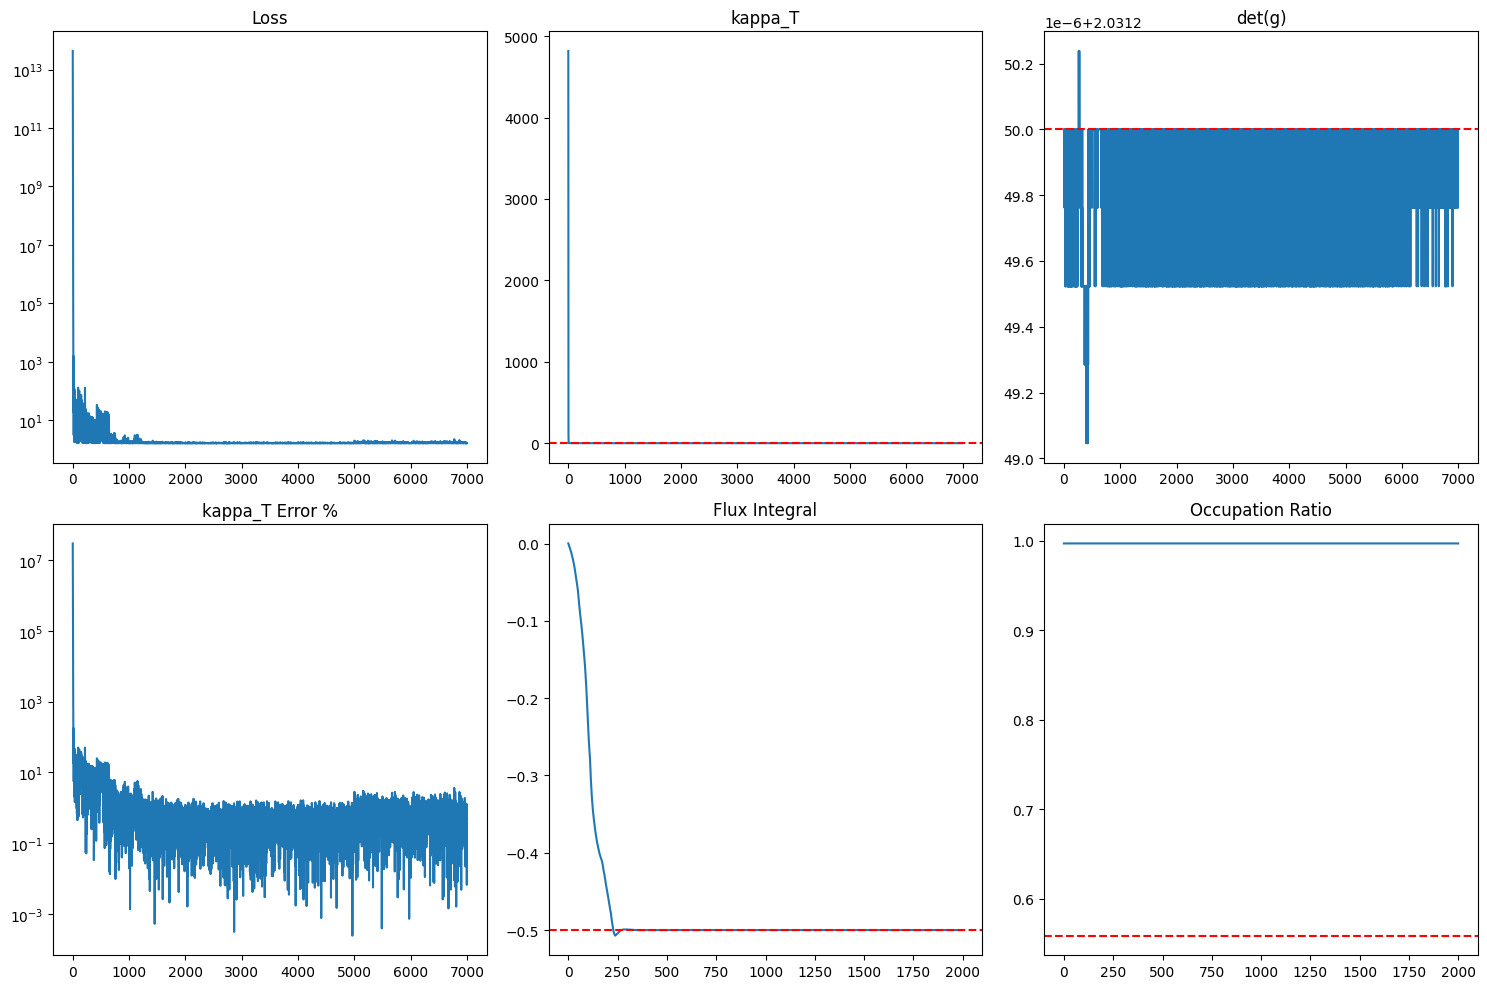


[3] FLUX PROFILE


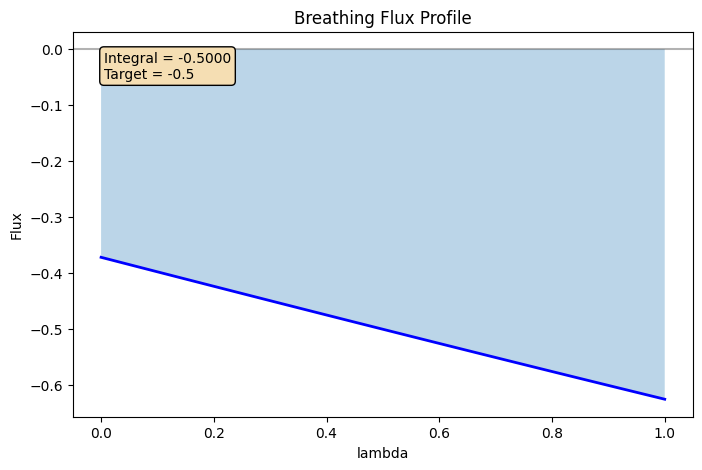


[4] BREATHING PERIOD ANALYSIS
  Estimated period: 0.3350 (target tau = 3.8967)

FINAL SUMMARY

[TOPOLOGICAL TARGETS]
  kappa_T = 0.016297  (target: 0.016393, error: 0.59%)
  det(g)  = 2.031250  (target: 2.031250, error: 0.00%)

[BREATHING DIAGNOSTICS]
  Flux integral = -0.5000  (target: -0.5)
  Occupation    = 0.9994  (target: 0.5584)
  Period        = 0.3350  (target: 3.8967)

[METRIC FIT]
  Average R^2 = 0.0032

K7 BREATHING v1.8 - COMPLETE


In [64]:
# =============================================================================
# RUN POST-HOC ANALYSIS (Enhanced)
# =============================================================================

print("\n" + "=" * 70)
print("POST-HOC ANALYSIS")
print("=" * 70)

# 1. Metric Fitting
print("\n[1] METRIC FITTING")
fit_results = fit_metric_ansatz(results['phi_net'], results['config'], DEVICE)

# 2. Training History Plot
print("\n[2] TRAINING HISTORY")
plot_training_history(results['history'], str(OUTPUT_DIR / "training_history.png"))

# 3. Flux Profile
if results['config'].breathing.enable:
    print("\n[3] FLUX PROFILE")
    plot_flux_profile(results['flux_net'], DEVICE, str(OUTPUT_DIR / "flux_profile.png"))

# 4. Breathing Period Estimation
print("\n[4] BREATHING PERIOD ANALYSIS")
with torch.no_grad():
    n_lambda = 200
    lam_sorted = torch.linspace(0, 1, n_lambda, device=DEVICE)
    coords_scan = torch.zeros(n_lambda, 7, device=DEVICE)
    coords_scan[:, 0] = lam_sorted
    coords_scan[:, 1:] = 0.5  # Fix transverse coords

    phi_scan = results['phi_net'](coords_scan)
    modes_scan = results['h3_extractor'](phi_scan, coords_scan)
    O_breathing = compute_breathing_observable(modes_scan, results['mode_proj'])

    period, period_info = estimate_breathing_period(O_breathing, lam_sorted)
    print(f"  Estimated period: {period:.4f} (target tau = {3472/891:.4f})")

# 5. Final Summary
print("\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)
core = results['final_core_metrics']
breath = results['final_breathing_metrics']

print(f"\n[TOPOLOGICAL TARGETS]")
print(f"  kappa_T = {core['kappa_T']:.6f}  (target: {1/61:.6f}, error: {core['kappa_T_error_pct']:.2f}%)")
print(f"  det(g)  = {core['det_g_mean']:.6f}  (target: {65/32:.6f}, error: {core['det_g_error_pct']:.2f}%)")

print(f"\n[BREATHING DIAGNOSTICS]")
print(f"  Flux integral = {breath['flux_integral']:.4f}  (target: -0.5)")
print(f"  Occupation    = {breath['occupation_vis']:.4f}  (target: {43/77:.4f})")
print(f"  Period        = {period:.4f}  (target: {3472/891:.4f})")

print(f"\n[METRIC FIT]")
print(f"  Average R^2 = {fit_results['avg_r_squared']:.4f}")

print("\n" + "=" * 70)
print("K7 BREATHING v1.8 - COMPLETE")
print("=" * 70)

In [65]:
# =============================================================================
# EXPORT ALL RESULTS (npy, pt, json)
# =============================================================================

print("\n" + "=" * 70)
print("EXPORTING RESULTS")
print("=" * 70)

# 1. Export metrics as JSON
metrics_export = {
    'geometry': {
        'kappa_T': results['final_core_metrics']['kappa_T'],
        'kappa_T_target': 1/61,
        'kappa_T_error_pct': results['final_core_metrics']['kappa_T_error_pct'],
        'det_g': results['final_core_metrics']['det_g_mean'],
        'det_g_target': 65/32,
        'det_g_error_pct': results['final_core_metrics']['det_g_error_pct'],
    },
    'breathing': {
        'flux_integral': results['final_breathing_metrics']['flux_integral'],
        'flux_target': -0.5,
        'occupation_vis': results['final_breathing_metrics']['occupation_vis'],
        'occupation_target': 43/77,
        'period_estimated': period,
        'period_target': 3472/891,
    },
    'metric_fit': {
        'avg_r_squared': fit_results['avg_r_squared'],
    },
    'training': {
        'total_epochs': len(results['history'].history['epoch']),
        'phase1_epochs': CONFIG.training.n_epochs_core,
        'phase2_epochs': CONFIG.training.n_epochs_breathing,
    }
}

with open(OUTPUT_DIR / "final_metrics.json", 'w') as f:
    json.dump(metrics_export, f, indent=2)
print(f"  Saved: {OUTPUT_DIR / 'final_metrics.json'}")

# 2. Export model weights as PT
torch.save({
    'phi_net_state': results['phi_net'].state_dict(),
    'flux_net_state': results['flux_net'].state_dict(),
    'config': results['config'].to_dict(),
    'metrics': metrics_export
}, OUTPUT_DIR / "model_complete.pt")
print(f"  Saved: {OUTPUT_DIR / 'model_complete.pt'}")

# 3. Export training history as NPY
np.savez(OUTPUT_DIR / "training_history.npz",
         epochs=np.array(results['history'].history['epoch']),
         loss=np.array(results['history'].history['total_loss']),
         kappa_T=np.array(results['history'].history['kappa_T']),
         det_g=np.array(results['history'].history['det_g']),
         flux=np.array([v if not np.isnan(v) else 0 for v in results['history'].history['flux_integral']]),
         occupation=np.array([v if not np.isnan(v) else 0 for v in results['history'].history['occupation_vis']]))
print(f"  Saved: {OUTPUT_DIR / 'training_history.npz'}")

# 4. Export metric fitting coefficients
with open(OUTPUT_DIR / "metric_fit_coefficients.json", 'w') as f:
    json.dump(fit_results, f, indent=2)
print(f"  Saved: {OUTPUT_DIR / 'metric_fit_coefficients.json'}")

# 5. Sample phi and metric values for analysis
print("\n[SAMPLING PHI AND METRIC FOR EXPORT]")
with torch.no_grad():
    sample_coords_export = sample_TCS_coords(1000, DEVICE)
    sample_phi = results['phi_net'](sample_coords_export)
    sample_metric = project_spd(metric_from_phi(sample_phi))

np.savez(OUTPUT_DIR / "samples.npz",
         coords=sample_coords_export.cpu().numpy(),
         phi=sample_phi.cpu().numpy(),
         metric=sample_metric.cpu().numpy())
print(f"  Saved: {OUTPUT_DIR / 'samples.npz'}")

# List all outputs
print("\n[OUTPUT FILES]")
for f in sorted(OUTPUT_DIR.glob("*")):
    if f.is_file():
        size = f.stat().st_size
        print(f"  {f.name:40s} ({size/1024:.1f} KB)")


EXPORTING RESULTS
  Saved: outputs_v1_8/final_metrics.json
  Saved: outputs_v1_8/model_complete.pt
  Saved: outputs_v1_8/training_history.npz
  Saved: outputs_v1_8/metric_fit_coefficients.json

[SAMPLING PHI AND METRIC FOR EXPORT]
  Saved: outputs_v1_8/samples.npz

[OUTPUT FILES]
  config.json                              (1.0 KB)
  final_metrics.json                       (0.6 KB)
  final_model.pt                           (486.4 KB)
  flux_profile.png                         (38.7 KB)
  metric_fit_coefficients.json             (15.4 KB)
  model_complete.pt                        (487.8 KB)
  samples.npz                              (356.2 KB)
  training_history.json                    (1477.1 KB)
  training_history.npz                     (329.6 KB)
  training_history.png                     (132.0 KB)


In [66]:
# =============================================================================
# YUKAWA TENSOR EXTRACTION (Optional - takes 5-15 min)
# =============================================================================

RUN_YUKAWA = True  # Set to False to skip

if RUN_YUKAWA:
    print("\n" + "=" * 70)
    print("YUKAWA TENSOR EXTRACTION")
    print("=" * 70)

    yukawa_ext = YukawaCouplingExtractor(n_samples=5000)
    Y = yukawa_ext.compute_yukawa_tensor(
        results['phi_net'], results['h2_extractor'],
        results['h3_extractor'], CONFIG.geometry, DEVICE
    )

    # Analyze
    yukawa_analysis = yukawa_ext.analyze_yukawa(Y)
    print(f"\nYukawa tensor shape: {Y.shape}")
    print(f"Effective rank: {yukawa_analysis['effective_rank']}/77")
    print(f"Top 5 singular values: {[f'{s:.4f}' for s in yukawa_analysis['top_singular']]}")

    # Save
    torch.save(Y, OUTPUT_DIR / "yukawa_tensor.pt")
    np.save(OUTPUT_DIR / "yukawa_tensor.npy", Y.cpu().numpy())

    with open(OUTPUT_DIR / "yukawa_analysis.json", 'w') as f:
        json.dump({
            'shape': list(Y.shape),
            'effective_rank': yukawa_analysis['effective_rank'],
            'top_singular': yukawa_analysis['top_singular'],
            'frobenius_norm': torch.norm(Y).item(),
            'max_value': Y.abs().max().item(),
            'n_samples': yukawa_ext.n_samples
        }, f, indent=2)

    print(f"\nSaved: yukawa_tensor.pt, yukawa_tensor.npy, yukawa_analysis.json")
else:
    print("\n[Yukawa extraction skipped - set RUN_YUKAWA=True to enable]")


YUKAWA TENSOR EXTRACTION
Computing Yukawa tensor (21x21x77)...

Yukawa tensor shape: torch.Size([21, 21, 77])
Effective rank: 1/77
Top 5 singular values: ['75.4156', '0.0000', '0.0000', '0.0000', '0.0000']

Saved: yukawa_tensor.pt, yukawa_tensor.npy, yukawa_analysis.json
